First 5 rows of the dataset:
   survey_code  age  gender      height     weight        bmi  bmi_estimated  \
0            1   56    Male  173.416872  56.886640  18.915925      18.915925   
1            2   69  Female  163.207380  97.799859  36.716278      36.716278   
2            3   46    Male  177.281966  80.687562  25.673050      25.673050   
3            4   32  Female  172.101255  63.142868  21.318480      21.318480   
4            5   60  Female  163.608816  40.000000  14.943302      14.943302   

   bmi_scaled  bmi_corrected  waist_size  ...  sunlight_exposure  \
0   56.747776      18.989117   72.165130  ...               High   
1  110.148833      36.511417   85.598889  ...               High   
2   77.019151      25.587429   90.295030  ...               High   
3   63.955440      21.177109  100.504211  ...               High   
4   44.829907      14.844299   69.021150  ...               High   

   meals_per_day  caffeine_intake  family_history  pet_owner  \
0              5 

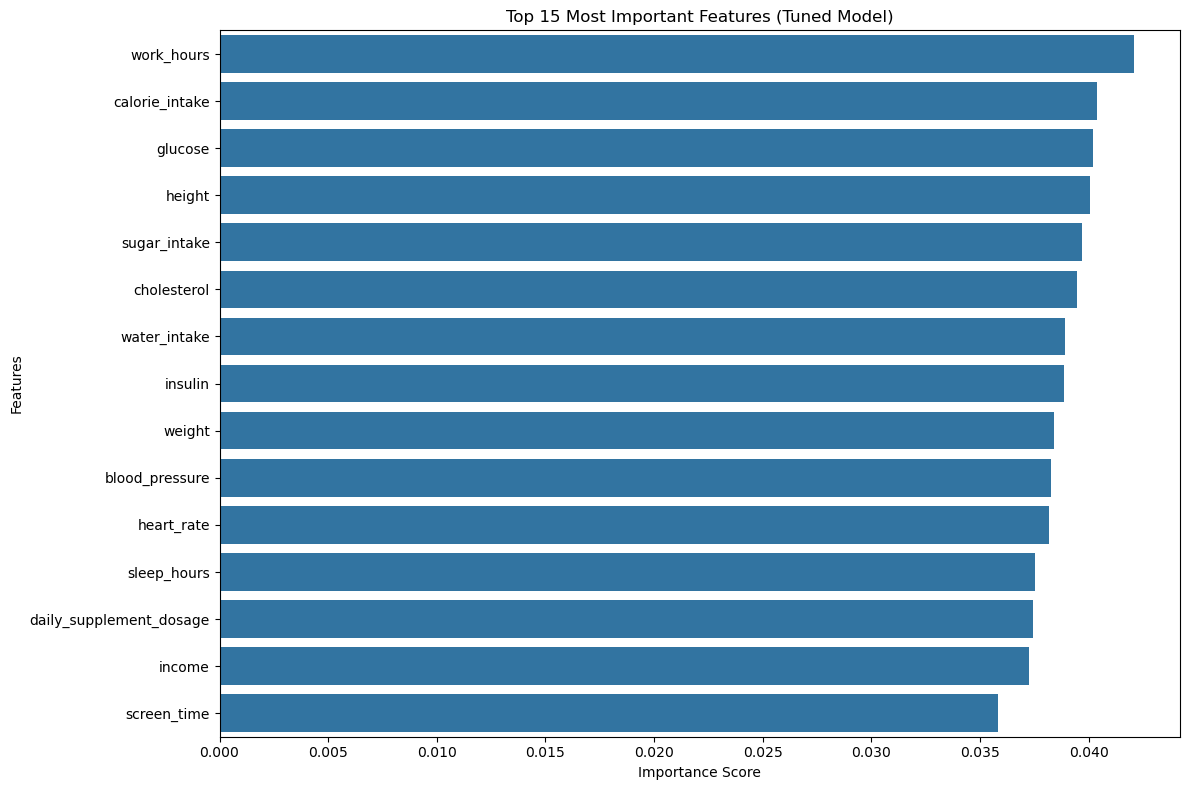

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Define the file path to your dataset
file_path = r"C:\Users\monik\health_lifestyle_classification.csv"

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)

# --- Initial Data Inspection ---
print("First 5 rows of the dataset:")
print(df.head())

print("\nNull value counts before cleaning:")
print(df.isnull().sum())


# --- Data Cleaning and Preparation ---

# Select all columns except 'survey_code' which is just an identifier
features_to_use = df.drop('survey_code', axis=1)

# Separate features and target
X_features = features_to_use.drop('target', axis=1)
Y_target = features_to_use['target']

# One-hot encode all categorical features
X_encoded = pd.get_dummies(X_features, drop_first=True)

# Impute missing values in the feature set
imputer = SimpleImputer(strategy='mean')
X_imputed_array = imputer.fit_transform(X_encoded)
X_imputed = pd.DataFrame(X_imputed_array, columns=X_encoded.columns)

# Encode the target variable
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y_target)


# --- Hyperparameter Tuning with RandomizedSearchCV ---

# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_imputed, Y_encoded, test_size=0.2, random_state=42, stratify=Y_encoded)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Initialize RandomizedSearchCV
# n_iter and cv have been reduced to speed up the process.
# A higher n_iter and cv will result in a more thorough search but will take longer.
rf_random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, 
                                      n_iter=10, cv=2, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
print("\nStarting hyperparameter tuning with RandomizedSearchCV...")
rf_random_search.fit(X_train_scaled, Y_train)

# Get the best model from the search
best_rf_model = rf_random_search.best_estimator_
print("\nBest parameters found:")
print(rf_random_search.best_params_)


# --- Model Evaluation ---

# Make predictions with the best model
Y_pred = best_rf_model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(Y_test, Y_pred)
conf_matrix = confusion_matrix(Y_test, Y_pred)

print("\n--- Tuned Random Forest Model Evaluation ---")
print(f"Test Accuracy: {accuracy:.4f}")
print("\nTest Confusion Matrix:")
print(conf_matrix)


# --- Feature Importance Visualization ---

# Get feature importances from the best model
importances = best_rf_model.feature_importances_
feature_names = X_imputed.columns

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False).head(15) # Top 15 features

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Top 15 Most Important Features (Tuned Model)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


In [ ]:
The most critical piece of information is the Test Confusion Matrix:
[[    0   5981]
[    0  14819]]

This matrix tells us how the model's predictions compare to the actual outcomes. Here's how to read it:

Top-Left (True Negatives): 0 - The model correctly predicted 'diseased' 0 times.

Top-Right (False Positives): 5981 - The model incorrectly predicted 'healthy' 5981 times when the person was actually 'diseased'.

Bottom-Left (False Negatives): 0 - The model incorrectly predicted 'diseased' 0 times when the person was actually 'healthy'.

Bottom-Right (True Positives): 14819 - The model correctly predicted 'healthy' 14819 times.

Conclusion
The Model is Not Learning Effectively: The confusion matrix shows that the model is only predicting one class ('healthy'). It never once predicts that an outcome is 'diseased'. This is a classic sign that the model has failed to learn the patterns that distinguish between the two classes, likely due to an imbalance in the dataset (many more 'healthy' samples than 'diseased' ones).

The Accuracy Score is Misleading: While the model might have a decent accuracy score, it's not a useful metric here. The model is achieving its accuracy simply by guessing the most common class every single time.

Feature Importances are Unreliable: Because the model isn't making meaningful predictions, the feature importance plot should be viewed with skepticism. While it lists work_hours, calorie_intake, and glucose as the most important features, these are likely just the features most correlated with the majority ('healthy') class. They are not necessarily the best features for distinguishing between the two outcomes.

In short, the model has collapsed and is not a useful predictor in its current state.